In [70]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# TPHM 模型

首先，让我们弄清楚模型的公式和参数。TPHM模型使用两个参数来描述径流与流域储存和降雨深度之间的关系。模型的公式由两部分组成：

1. 计算每天的径流深度 (Q_t)。这部分使用了一个结合了双曲正切函数和幂函数的公式，它反映了流域储存 (S_{t-1}) 和当天的降雨深度 (P_t) 对径流的影响。模型使用的公式如下：

$$ Q_{t} = [\tanh((S_{t-1} + P_{t}) / S_{\text{max}})]^{\alpha} * (S_{t-1} + P_{t}) $$


其中，S_{max} 是流域的储存容量，α 是一个描述流域对降雨反应的迅速性的参数。S_{max} 减小，直接径流增加。α 接近1时，时间流量变化性更大。

2. 更新流域的每日储存量 (S_t)。这部分是通过对前一天的储存量 (S_{t-1}) 添加当天的降雨深度 (P_t)，然后减去径流 (Q_t) 和实际蒸发蒸腾量 (ET_{a,t}) 来实现的。公式如下：

$$ S_{t} = S_{t-1} + P_{t} - Q_{t} - ET_{a,t} $$


其中，ET_{a,t} 是当天的实际蒸发蒸腾量。

下一步，我们需要获取模型需要的输入数据，包括每日降雨量 (P_t)，每日实际蒸发蒸腾量 (ET_{a,t})，以及流域的初始储存量 (S_0)。这些数据可能需要通过观测或其他模型来获取。我们还需要设定模型的两个参数 (S_{max} 和 α)，这可以通过对历史数据的拟合或灵敏度分析来进行。

得到这些数据和参数后，我们就可以按照以下步骤来运行模型：

1. 设置初始的流域储存量为 S_0。

2. 对于每一天 t，计算径流深度 Q_t 和新的流域储存量 S_t。

3. 使用新的流域储存量 S_t 作为下一天的起始储存量。

4. 重复步骤2和3，直到所有的天数都被处理完。

这个模型的结果可以用来预测未来的径流量，或者用来理解流域对降雨的反应。

In [74]:
import numpy as np

# TPHM model parameters
S_max = 30  # max storage capacity of the watershed, adjust as needed
alpha = 0.8   # promptness of the watershed response to rainfall, adjust as needed
k = 0.85  # crop coefficient

def calculate_runoff_and_storage(S_t_1, P_t, ET_o_t,params):
    """
    Calculate the daily runoff and update the daily storage.
    
    Inputs:
    S_t_1: Storage from the previous day (mm)
    P_t: Daily rainfall (mm)
    ET_a_t: Daily actual evapotranspiration (mm)
    
    Outputs:
    Q_t: Daily runoff (mm)
    S_t: Daily storage (mm)
    """
    S_max, alpha, k = params
    ET_a_t = ET_o_t * k

    # Step 1: Calculate daily runoff using the following formula
    Q_t = np.tanh((S_t_1 ) / S_max)**alpha * (S_t_1)

    
    # Step 2: Update daily storage using the following formula
    S_t = S_t_1 + P_t - Q_t - ET_a_t
    
    # Make sure Q_t and S_t are positive
    S_t = np.maximum(0.001, S_t)

    return Q_t, S_t

# Define a function to calculate Mean Squared Error
def calculate_mse(params, P, Q_obs, ETo):  
    # Initialize storage and runoff arrays
    S = np.empty_like(P)
    Q = np.empty_like(P)

    # Set initial storage
    S[0] = 2

    # Run the model
    for t in range(1, len(P)):  # start from 1 because we've already set the initial storage
            Q[t], S[t] = calculate_runoff_and_storage(S[t-1], P[t], ETo[t], params)

    # Calculate MSE between observed and calculated Q
    mse = mean_squared_error(Q_obs, Q)

    return mse

In [79]:
# Daily rainfall and actual evapotranspiration data for a period of time
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
P = fengqiao['precipitation'].values
Q_obs = fengqiao['discharge'].values
ETo = mete['ETo_PM'].values

# Initialize storage and runoff arrays
S = np.empty_like(P)
Q = np.empty_like(P)

# Initial guess for the parameters
initial_guess = [30, 0.8, 0.85]

# Bounds for the parameters
bounds = [(1, 50), (-1, 1), (0, 2)]

# Find the parameters that minimize the MSE
result = minimize(calculate_mse, initial_guess, args=(P, Q_obs, ETo), method='L-BFGS-B', bounds=bounds)

# Print the optimal parameters
print("Optimal parameters:")
print("S_max: ", result.x[0])
print("alpha: ", result.x[1])
print("k: ", result.x[2])


Optimal parameters:
S_max:  50.0
alpha:  -1.0
k:  0.0


/tmp/ipykernel_343867/884451830.py:25: RuntimeWarning: overflow encountered in double_scalars
  Q_t = np.tanh((S_t_1 ) / S_max)**alpha * (S_t_1)


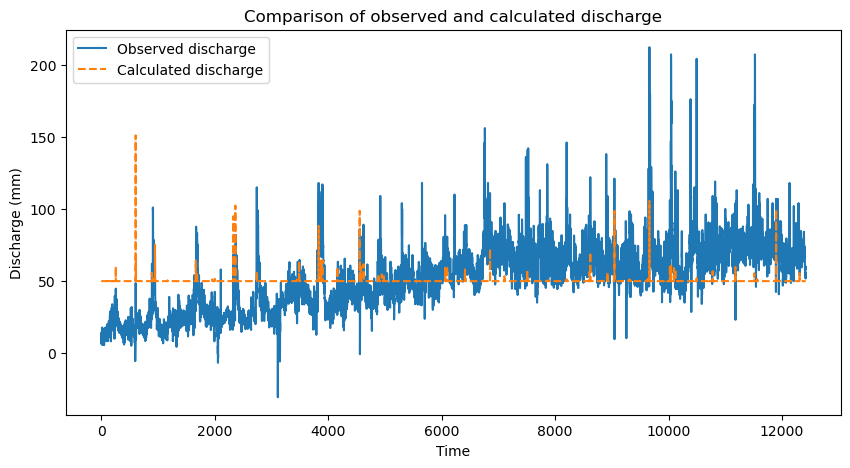

In [80]:
import matplotlib.pyplot as plt

# Get the optimal parameters
S_max_opt, alpha_opt, k_opt = result.x

# Run the model again with the optimal parameters
for t in range(1, len(P)):  # start from 1 because we've already set the initial storage
    Q[t], S[t] = calculate_runoff_and_storage(S[t-1], P[t], ETo[t], [S_max_opt, alpha_opt, k_opt])

# Plot the observed and calculated discharge
plt.figure(figsize=(10,5))
plt.plot(Q_obs, label='Observed discharge')
plt.plot(Q, label='Calculated discharge', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Discharge (mm)')
plt.legend()
plt.title('Comparison of observed and calculated discharge')
plt.show()

# 总结

计算公式没有任何意思